In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd
import sys
import linmix
%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

sys.path.append(sed_fit_dir)
import models as bat_mod
from fitting import Filters 
import pickle
import os

In [2]:
# Setup the figures
execfile('../code/figure-setup.py')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# Upload the fitting results for the C12 model
bat_c12 = pd.read_csv('../data/bat-agn-c12-params.csv', index_col=0)

# Remove 'bad' sources
radio_loud_sources = np.array(['PICTORA', '3C111.0', '3C120',
                              '2MASXJ23272195+1524375', 'PKS2331-240',
                              'HB890241+622', 'Mrk3'])
bat_c12 = bat_c12.drop(radio_loud_sources)
#bat_c12.loc['UGC06728', 'lir_sf'] += 2.0
#bat_c12.loc['UGC06728', 'mdust'] += 2.0

# Add in quadrature an uncertainty of 0.15 for f_AGN and 0.2 dex for the luminosities
bat_c12['agn_frac_err_high'] = np.sqrt(bat_c12['agn_frac_err_high']**2 + 0.1**2)
bat_c12['agn_frac_err_low'] = np.sqrt(bat_c12['agn_frac_err_low']**2 + 0.1**2)
bat_c12['lir_sf_err_high'] = np.sqrt(bat_c12['lir_sf_err_high']**2 + 0.2**2)
bat_c12['lir_sf_err_low'] = np.sqrt(bat_c12['lir_sf_err_low']**2 + 0.2**2)
bat_c12['lir_agn_err_high'] = np.sqrt(bat_c12['lir_agn_err_high']**2 + 0.2**2)
bat_c12['lir_agn_err_low'] = np.sqrt(bat_c12['lir_agn_err_low']**2 + 0.2**2)

In [4]:
# Upload the WISE and Herschel data
# Upload the BAT fluxes for Herschel and WISE
herschel_data = pd.read_csv(data_dir+'bat_herschel.csv', index_col=0,
                            na_values=0)
wise_data = pd.read_csv(data_dir+'bat_wise.csv', index_col=0,
                        usecols=[0, 1, 2, 4, 5, 7, 8, 10, 11], na_values=0)

# SPIRE fluxes that are seriously contaminated by a companion should be upper limits
psw_flag = herschel_data['PSW_flag']
pmw_flag = herschel_data['PMW_flag']
plw_flag = herschel_data['PLW_flag']

herschel_data['PSW_err'][psw_flag == 'AD'] = herschel_data['PSW'][psw_flag == 'AD']
herschel_data['PSW'][psw_flag == 'AD'] = np.nan
herschel_data['PMW_err'][pmw_flag == 'AD'] = herschel_data['PMW'][pmw_flag == 'AD']
herschel_data['PMW'][pmw_flag == 'AD'] = np.nan
herschel_data['PLW_err'][plw_flag == 'AD'] = herschel_data['PLW'][plw_flag == 'AD']
herschel_data['PLW'][plw_flag == 'AD'] = np.nan

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ttshimiz/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning

In [5]:
ind_w3_h70 = (herschel_data['PACS70'] > 0) & (wise_data['W3'] > 0)
rho_w3_h70 = stats.pearsonr(wise_data.loc[ind_w3_h70, 'W3'], herschel_data.loc[ind_w3_h70, 'PACS70'])

ind_w3_h160 = (herschel_data['PACS160'] > 0) & (wise_data['W3'] > 0)
rho_w3_h160 = stats.pearsonr(wise_data.loc[ind_w3_h160, 'W3'], herschel_data.loc[ind_w3_h160, 'PACS160'])

ind_w3_h250 = (herschel_data['PSW'] > 0) & (wise_data['W3'] > 0)
rho_w3_h250 = stats.pearsonr(wise_data.loc[ind_w3_h250, 'W3'], herschel_data.loc[ind_w3_h250, 'PSW'])

ind_w4_h70 = (herschel_data['PACS70'] > 0) & (wise_data['W4'] > 0)
rho_w4_h70 = stats.pearsonr(wise_data.loc[ind_w4_h70, 'W4'], herschel_data.loc[ind_w4_h70, 'PACS70'])

ind_w4_h160 = (herschel_data['PACS160'] > 0) & (wise_data['W4'] > 0)
rho_w4_h160 = stats.pearsonr(wise_data.loc[ind_w4_h160, 'W4'], herschel_data.loc[ind_w4_h160, 'PACS160'])

ind_w4_h250 = (herschel_data['PSW'] > 0) & (wise_data['W4'] > 0)
rho_w4_h250 = stats.pearsonr(wise_data.loc[ind_w4_h250, 'W4'], herschel_data.loc[ind_w4_h250, 'PSW'])

print 'Correlation Coefficients:'
print 'W3 vs. H70: ', rho_w3_h70[0]
print 'W3 vs. H160: ', rho_w3_h160[0]
print 'W3 vs. H250: ', rho_w3_h250[0]
print 'W4 vs. H70: ', rho_w4_h70[0]
print 'W4 vs. H160: ', rho_w4_h160[0]
print 'W4 vs. H250: ', rho_w4_h250[0]

Correlation Coefficients:
W3 vs. H70:  0.971028309711
W3 vs. H160:  0.982907747133
W3 vs. H250:  0.972926927368
W4 vs. H70:  0.968586242596
W4 vs. H160:  0.954663554701
W4 vs. H250:  0.949596327685


In [6]:
use_sources = bat_c12[bat_c12['agn_frac_flag'] <= 0].index
flux_ratios = pd.DataFrame(index=use_sources)

flux_ratios['agn_frac'] = bat_c12['agn_frac']
flux_ratios['agn_frac_err_low'] = bat_c12['agn_frac_err_low']
flux_ratios['agn_frac_err_high'] = bat_c12['agn_frac_err_high']
flux_ratios['agn_frac_flag'] = bat_c12['agn_frac_flag']

flux_ratios['W1/W2'] = wise_data['W1']/wise_data['W2']
flux_ratios['W2/W3'] = wise_data['W2']/wise_data['W3']
flux_ratios['W3/W4'] = wise_data['W3']/wise_data['W4']
flux_ratios['W3/H70'] = wise_data['W3']/herschel_data['PACS70']
flux_ratios['W3/H70_err'] = flux_ratios['W3/H70']*np.sqrt((wise_data['W3_err']/wise_data['W3'])**2 +
                            (herschel_data['PACS70_err']/herschel_data['PACS70'])**2 -
                            (2*0.97*wise_data['W3_err']*herschel_data['PACS70_err']/wise_data['W3']/herschel_data['PACS70']))
flux_ratios['W3/H160'] = wise_data['W3']/herschel_data['PACS160']
flux_ratios['W3/H160_err'] = flux_ratios['W3/H160']*np.sqrt((wise_data['W3_err']/wise_data['W3'])**2 +
                            (herschel_data['PACS160_err']/herschel_data['PACS160'])**2 -
                            (2*0.98*wise_data['W3_err']*herschel_data['PACS160_err']/wise_data['W3']/herschel_data['PACS160']))
flux_ratios['W3/H250'] = wise_data['W3']/herschel_data['PSW']
flux_ratios['W3/H250_err'] = flux_ratios['W3/H250']*np.sqrt((wise_data['W3_err']/wise_data['W3'])**2 +
                            (herschel_data['PSW_err']/herschel_data['PSW'])**2 -
                            (2*0.97*wise_data['W3_err']*herschel_data['PSW_err']/wise_data['W3']/herschel_data['PSW']))
flux_ratios['W4/H70'] = wise_data['W4']/herschel_data['PACS70']
flux_ratios['W4/H70_err'] = flux_ratios['W4/H70']*np.sqrt((wise_data['W4_err']/wise_data['W4'])**2 +
                            (herschel_data['PACS70_err']/herschel_data['PACS70'])**2 -
                            (2*0.97*wise_data['W4_err']*herschel_data['PACS70_err']/wise_data['W4']/herschel_data['PACS70']))
flux_ratios['W4/H160'] = wise_data['W4']/herschel_data['PACS160']
flux_ratios['W4/H160_err'] = flux_ratios['W4/H160']*np.sqrt((wise_data['W4_err']/wise_data['W4'])**2 +
                            (herschel_data['PACS160_err']/herschel_data['PACS160'])**2 -
                            (2*0.95*wise_data['W4_err']*herschel_data['PACS160_err']/wise_data['W4']/herschel_data['PACS160']))
flux_ratios['W4/H250'] = wise_data['W4']/herschel_data['PSW']
flux_ratios['W4/H250_err'] = flux_ratios['W4/H250']*np.sqrt((wise_data['W4_err']/wise_data['W4'])**2 +
                            (herschel_data['PSW_err']/herschel_data['PSW'])**2 -
                            (2*0.95*wise_data['W4_err']*herschel_data['PSW_err']/wise_data['W4']/herschel_data['PSW']))
flux_ratios['H70/H160'] = herschel_data['PACS70']/herschel_data['PACS160']
flux_ratios['H70/H250'] = herschel_data['PACS70']/herschel_data['PSW']
flux_ratios['H160/H250'] = herschel_data['PACS160']/herschel_data['PSW']

In [7]:
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv',
                        index_col=0)

# Remove the BAT AGN in the HRS
hrs_casey = hrs_casey.drop([4,144,288,296])

hrs_casey['agn_frac'] = (10**hrs_casey['lir_powlaw'] - 1./3.*10**hrs_casey['lir_bb'])/10**(hrs_casey['lir_total'])
hrs_data = pd.read_table('../../hrs-data/hrs_photometry.txt', index_col=0)
hrs_sed = pd.DataFrame({'W3': hrs_data['S12'], 'W4': hrs_data['S22'],
                        'PACS100': hrs_data['S100']*1000, 'PACS160': hrs_data['S160']*1000,
                        'PSW': hrs_data['S250'], 'PMW': hrs_data['S350'],
                        'PLW': hrs_data['S500']})
hrs_err = pd.DataFrame({'W3_err': hrs_data['err12'], 'W4_err': hrs_data['err22'],
                        'PACS100_err': hrs_data['err100']*1000, 'PACS160_err': hrs_data['err160']*1000,
                        'PSW_err': hrs_data['err_tot250'], 'PMW_err': hrs_data['err_tot350'],
                        'PLW_err': hrs_data['err_tot500']})
hrs_flag = hrs_data[['Flag12', 'Flag22', 'Flag100', 'Flag160', 'Flag250', 'Flag350', 'Flag500']]

hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag12'] == 0, 'W3_err']
hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err'] = 5./3.*hrs_err.loc[hrs_flag['Flag22'] == 0, 'W4_err']
hrs_err.loc[hrs_flag['Flag100'] == 0, 'PACS100_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100']
hrs_err.loc[hrs_flag['Flag160'] == 0, 'PACS160_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160']
hrs_err.loc[hrs_flag['Flag250'] == 0, 'PSW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW']
hrs_err.loc[hrs_flag['Flag350'] == 0, 'PMW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW']
hrs_err.loc[hrs_flag['Flag500'] == 0, 'PLW_err'] = 5./3.*hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW']

hrs_sed.loc[hrs_flag['Flag12'] == 0, 'W3'] = np.nan
hrs_sed.loc[hrs_flag['Flag22'] == 0, 'W4'] = np.nan
hrs_sed.loc[hrs_flag['Flag100'] == 0, 'PACS100'] = np.nan
hrs_sed.loc[hrs_flag['Flag160'] == 0, 'PACS160'] = np.nan
hrs_sed.loc[hrs_flag['Flag250'] == 0, 'PSW'] = np.nan
hrs_sed.loc[hrs_flag['Flag350'] == 0, 'PMW'] = np.nan
hrs_sed.loc[hrs_flag['Flag500'] == 0, 'PLW'] = np.nan

In [25]:
flux_ratios_hrs = pd.DataFrame(index=hrs_sed.index)
filters = Filters()
pacs70_waves = filters.get_waves('PACS70')
# Estimate the 70 micron flux for HRS based on best fit models
for n in flux_ratios_hrs.index:
    f = casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/pickles/HRS'+str(n)+'_casey_bayes_beta_fixed_2_wturn_gaussianPrior.pickle'
    if os.path.exists(f):
        file_result = open(f, 'rb')
        fit_result = pickle.load(file_result)
        file_result.close()
        mod = fit_result['best_fit_model']
        sed = mod(pacs70_waves)
        hrs_sed.loc[n, 'PACS70'] = filters.calc_mono_flux('PACS70', pacs70_waves, sed)

flux_ratios_hrs['W3/H70'] = hrs_sed['W3']/(hrs_sed['PACS70']*1000)
flux_ratios_hrs['W3/H160'] = hrs_sed['W3']/hrs_sed['PACS160']
flux_ratios_hrs['W3/H250'] = hrs_sed['W3']/hrs_sed['PSW']
flux_ratios_hrs['W4/H70'] = hrs_sed['W4']/(hrs_sed['PACS70']*1000)
flux_ratios_hrs['W4/H160'] = hrs_sed['W4']/hrs_sed['PACS160']
flux_ratios_hrs['W4/H250'] = hrs_sed['W4']/hrs_sed['PSW']
flux_ratios_hrs['agn_frac'] = hrs_casey['agn_frac']

flux_ratios_hrs = flux_ratios_hrs.drop([4, 144, 288, 296])
hrs_data = hrs_data.drop([4, 144, 296])

KeyboardInterrupt: 

In [9]:
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv',
                       index_col=0)
kf_casey['agn_frac'] = (10**kf_casey['lir_powlaw'] - 1./3.*10**kf_casey['lir_bb'])/10**(kf_casey['lir_total'])
kf_dir = '/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/'
kf_data = pd.read_table(kf_dir+'kingfish_data.txt', delimiter='\t', index_col=0, na_values=0)

flux_ratios_kf = pd.DataFrame(index=kf_data.index)
flux_ratios_kf['W3/H70'] = kf_data['IRAC4']/kf_data['PACS70']
flux_ratios_kf['W3/H160'] = kf_data['IRAC4']/kf_data['PACS160']
flux_ratios_kf['W3/H250'] = kf_data['IRAC4']/kf_data['PSW']
flux_ratios_kf['W4/H70'] = kf_data['MIPS24']/kf_data['PACS70']
flux_ratios_kf['W4/H160'] = kf_data['MIPS24']/kf_data['PACS160']
flux_ratios_kf['W4/H250'] = kf_data['MIPS24']/kf_data['PSW']
flux_ratios_kf['agn_frac'] = kf_casey['agn_frac']

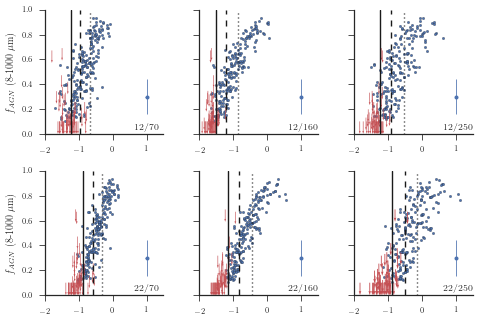

In [26]:
fig = plt.figure(figsize=(1.1*textwidth, 1.1*2./3.*textwidth))
mark_size = 6
avg_agn_frac_err = flux_ratios['agn_frac_err_high'][flux_ratios['agn_frac_flag']==0].mean()

ax1 = fig.add_subplot(231)
ax1.scatter(np.log10(flux_ratios['W3/H70'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0],
            c='b', s=mark_size)
ax1.quiver(np.log10(flux_ratios['W3/H70'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.005, color='r')
#ax1.scatter(np.log10(flux_ratios_kf['W3/H70']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
#ax1.axhline(0.0, color='k', ls='dashed')
w3_h70_25, w3_h70_50, w3_h70_75 = np.percentile(np.log10(flux_ratios['W3/H70'][ind_w3_h70]), q=[25, 50, 75])
ax1.axvline(w3_h70_25, color='k')
ax1.axvline(w3_h70_50, color='k', ls='dashed')
ax1.axvline(w3_h70_75, color='k', ls='dotted')
ax1.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W3/H70_err'][ind_w3_h70]/flux_ratios['W3/H70'][ind_w3_h70]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax1.text(0.75, 0.1, '12/70', ha='left', va='top', transform=ax1.transAxes)
ax1.locator_params(axis='x', nbins=5)
ax1.set_ylabel(r'$f_{AGN}$ (8-1000 $\mu$m)')
ax1.set_ylim(0, 1.0)
ax1.set_xlim(-2, 1.5)
#ax12 = ax1.twinx()
#sn.kdeplot(np.log10(flux_ratios_kf['W3/H160']), ax=ax12, color='r', legend=False)
#ax12_ylim = ax12.get_ylim()
#ax12.set_ylim((0, ax12_ylim[1]*3))
#ax12.yaxis.set_ticklabels([])
#ax12.yaxis.set_ticks([])
#ax12.set_xlim(-2, 1)
#ax1.set_ylim(0, 1)

ax2 = fig.add_subplot(232)
ax2.scatter(np.log10(flux_ratios['W3/H160'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0], c='b', s=mark_size)
ax2.quiver(np.log10(flux_ratios['W3/H160'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.005, color='r')
#ax2.scatter(np.log10(flux_ratios_hrs['W3/H160']), flux_ratios_hrs['agn_frac'], c='r', s=mark_size)
#ax2.scatter(np.log10(flux_ratios_kf['W3/H160']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
ax2.yaxis.set_ticklabels([])
w3_h160_25, w3_h160_50, w3_h160_75 = np.percentile(np.log10(flux_ratios['W3/H160'][ind_w3_h160]), q=[25, 50, 75])
ax2.axvline(w3_h160_25, color='k')
ax2.axvline(w3_h160_50, color='k', ls='dashed')
ax2.axvline(w3_h160_75, color='k', ls='dotted')
ax2.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W3/H160_err'][ind_w3_h160]/flux_ratios['W3/H160'][ind_w3_h160]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax2.text(0.75, 0.1, '12/160', ha='left', va='top', transform=ax2.transAxes)
ax2.locator_params(axis='x', nbins=5)
#ax2.axhline(0.0, color='k', ls='dashed')
ax2.set_ylim(0, 1.0)
ax2.set_xlim(-2, 1.5)
#ax22 = ax2.twinx()
#sn.kdeplot(np.log10(flux_ratios_hrs['W3/H160']), ax=ax22, color='r', legend=False)
#ax22_ylim = ax22.get_ylim()
#ax22.set_ylim((ax22_ylim[0], ax22_ylim[1]*3))
#ax22.yaxis.set_ticklabels([])
#ax22.yaxis.set_ticks([])
#ax22.set_xlim(-2, 1)
#ax2.set_ylim(0, 1)

ax3 = fig.add_subplot(233)
ax3.scatter(np.log10(flux_ratios['W3/H250'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0], c='b', s=mark_size)
ax3.quiver(np.log10(flux_ratios['W3/H250'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.005, color='r')
#ax3.scatter(np.log10(flux_ratios_hrs['W3/H250']), flux_ratios_hrs['agn_frac'], c='r', s=mark_size)
#ax3.scatter(np.log10(flux_ratios_kf['W3/H250']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
ax3.yaxis.set_ticklabels([])
w3_h250_25, w3_h250_50, w3_h250_75 = np.percentile(np.log10(flux_ratios['W3/H250'][ind_w3_h250]), q=[25, 50, 75])
ax3.axvline(w3_h250_25, color='k')
ax3.axvline(w3_h250_50, color='k', ls='dashed')
ax3.axvline(w3_h250_75, color='k', ls='dotted')
ax3.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W3/H250_err'][ind_w3_h250]/flux_ratios['W3/H250'][ind_w3_h250]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax3.text(0.75, 0.1, '12/250', ha='left', va='top', transform=ax3.transAxes)
ax3.locator_params(axis='x', nbins=5)
#ax3.axhline(0.0, color='k', ls='dashed')
ax3.set_ylim(0.0, 1.0)
ax3.set_xlim(-2, 1.5)
#ax32 = ax3.twinx()
#sn.kdeplot(np.log10(flux_ratios_hrs['W3/H250']), ax=ax32, color='r', legend=False)
#ax32_ylim = ax32.get_ylim()
#ax32.set_ylim((ax32_ylim[0], ax32_ylim[1]*3))
#ax32.yaxis.set_ticklabels([])
#ax32.yaxis.set_ticks([])
#ax32.set_xlim(-2, 1)

ax4 = fig.add_subplot(234)
ax4.scatter(np.log10(flux_ratios['W4/H70'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0], c='b', s=mark_size)
ax4.quiver(np.log10(flux_ratios['W4/H70'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.005, color='r')
#ax4.scatter(np.log10(flux_ratios_kf['W4/H70']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
ax4.set_ylabel(r'$f_{AGN}$ (8-1000 $\mu$m)')
w4_h70_25, w4_h70_50, w4_h70_75 = np.percentile(np.log10(flux_ratios['W4/H70'][ind_w4_h70]), q=[25, 50, 75])
ax4.axvline(w4_h70_25, color='k')
ax4.axvline(w4_h70_50, color='k', ls='dashed')
ax4.axvline(w4_h70_75, color='k', ls='dotted')
ax4.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W4/H70_err'][ind_w4_h70]/flux_ratios['W4/H70'][ind_w4_h70]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax4.text(0.75, 0.1, '22/70', ha='left', va='top', transform=ax4.transAxes)
ax4.locator_params(axis='x', nbins=5)
#ax4.axhline(0.0, color='k', ls='dashed')
ax4.set_ylim(0, 1.0)
ax4.set_xlim(-2, 1.5)
#ax42 = ax4.twinx()
#sn.kdeplot(np.log10(flux_ratios_kf['W4/H160']), ax=ax42, color='r', legend=False)
#ax42_ylim = ax42.get_ylim()
#ax42.set_ylim((ax42_ylim[0], ax42_ylim[1]*3))
#ax42.yaxis.set_ticklabels([])
#ax42.yaxis.set_ticks([])
#ax42.set_xlim(-2, 1)
#ax4.set_ylim(0, 1)

ax5 = fig.add_subplot(235)
ax5.scatter(np.log10(flux_ratios['W4/H160'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0], c='b', s=mark_size)
ax5.quiver(np.log10(flux_ratios['W4/H160'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.005, color='r')
#ax5.scatter(np.log10(flux_ratios_hrs['W4/H160']), flux_ratios_hrs['agn_frac'], c='r', s=mark_size)
#ax5.scatter(np.log10(flux_ratios_kf['W4/H160']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
ax5.yaxis.set_ticklabels([])
w4_h160_25, w4_h160_50, w4_h160_75 = np.percentile(np.log10(flux_ratios['W4/H160'][ind_w4_h160]), q=[25, 50, 75])
ax5.axvline(w4_h160_25, color='k')
ax5.axvline(w4_h160_50, color='k', ls='dashed')
ax5.axvline(w4_h160_75, color='k', ls='dotted')
ax5.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W4/H160_err'][ind_w3_h70]/flux_ratios['W4/H160'][ind_w4_h160]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax5.text(0.75, 0.1, '22/160', ha='left', va='top', transform=ax5.transAxes)
ax5.locator_params(axis='x', nbins=5)
#ax5.axhline(0.0, color='k', ls='dashed')
ax5.set_ylim(0, 1.0)
ax5.set_xlim(-2, 1.5)
#ax52 = ax5.twinx()
#sn.kdeplot(np.log10(flux_ratios_hrs['W4/H160']), ax=ax52, color='r', legend=False)
#ax52_ylim = ax52.get_ylim()
#ax52.set_ylim((ax52_ylim[0], ax52_ylim[1]*3))
#ax52.yaxis.set_ticklabels([])
#ax52.yaxis.set_ticks([])
#ax52.set_xlim(-2, 1)
#ax5.set_ylim(0, 1)

ax6 = fig.add_subplot(236)
ax6.scatter(np.log10(flux_ratios['W4/H250'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0], c='b', s=mark_size)
ax6.quiver(np.log10(flux_ratios['W4/H250'][flux_ratios['agn_frac_flag']==-1]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==-1],
           np.zeros(sum(flux_ratios['agn_frac_flag']==-1)), -np.ones(sum(flux_ratios['agn_frac_flag']==-1)),
           scale_units='height', scale=10., units='width', width=0.007, color='r')
#ax6.scatter(np.log10(flux_ratios_hrs['W4/H250']), flux_ratios_hrs['agn_frac'], c='r', s=mark_size)
#ax6.scatter(np.log10(flux_ratios_kf['W4/H250']), flux_ratios_kf['agn_frac'], c='r', s=mark_size)
ax6.yaxis.set_ticklabels([])
w4_h250_25, w4_h250_50, w4_h250_75 = np.percentile(np.log10(flux_ratios['W4/H250'][ind_w4_h250]), q=[25, 50, 75])
ax6.axvline(w4_h250_25, color='k')
ax6.axvline(w4_h250_50, color='k', ls='dashed')
ax6.axvline(w4_h250_75, color='k', ls='dotted')
ax6.errorbar(1.0, 0.3, yerr=avg_agn_frac_err,
             xerr=np.mean(0.434*flux_ratios['W4/H250_err'][ind_w3_h70]/flux_ratios['W4/H250'][ind_w4_h250]),
             fmt='o', markersize=4, ls='None', elinewidth=0.8)
ax6.text(0.75, 0.1, '22/250', ha='left', va='top', transform=ax6.transAxes)
ax6.locator_params(axis='x', nbins=5)
#ax6.axhline(0.0, color='k', ls='dashed')
ax6.set_ylim(0, 1.0)
ax6.set_xlim(-2, 1.5)
#ax62 = ax6.twinx()
#sn.kdeplot(np.log10(flux_ratios_hrs['W4/H250']), ax=ax62, color='r', legend=False)
#ax62_ylim = ax62.get_ylim()
#ax62.set_ylim((ax62_ylim[0], ax62_ylim[1]*3))
#ax62.yaxis.set_ticklabels([])
#ax62.yaxis.set_ticks([])
#ax62.set_xlim(-2, 1)

fig.subplots_adjust(hspace=0.3, wspace=0.3)
sn.despine()

fig.savefig(figsave_dir+'agnfrac_vs_flux_ratio.pdf', bbox_inches='tight')

In [11]:
def run_linmix(flux_ratio, flux_ratio_err, agn_frac, agn_frac_err, flag):
   
    x = np.log10(flux_ratio)
    y = agn_frac
    x_err = 0.434*flux_ratio_err/flux_ratio
    y_err = agn_frac_err
    delta = np.array(flag + 1, dtype=np.bool)
    
    lm = linmix.LinMix(x=x, y=y, xsig=x_err, ysig=y_err, delta=delta)
    lm.run_mcmc(silent=True)
                   
    beta = np.median(lm.chain['beta'])
    beta_err = np.std(lm.chain['beta'])
    alpha = np.median(lm.chain['alpha'])
    alpha_err = np.std(lm.chain['alpha'])
    sigsqr = np.median(lm.chain['sigsqr'])
    sigsqr_err = np.std(lm.chain['sigsqr'])
    corr = np.median(lm.chain['corr'])
    corr_err = np.std(lm.chain['corr'])
    
    return beta, beta_err, alpha, alpha_err, sigsqr, sigsqr_err, corr, corr_err

In [28]:
agn_frac = flux_ratios['agn_frac'][ind_w3_h70].values
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w3_h70], flux_ratios['agn_frac_err_low'][ind_w3_h70]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W3/H70'][ind_w3_h70].values
fr_err = flux_ratios['W3/H70_err'][ind_w3_h70].values
flag = flux_ratios['agn_frac_flag'][ind_w3_h70].values

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.668204018952 +/- 0.0361194929446
alpha =  1.02312673542 +/- 0.0334930308297
sigsqr =  0.0155709576477 +/- 0.0035344196301
corr =  0.892290351596 +/- 0.0232735923464


In [29]:
agn_frac = flux_ratios['agn_frac'][ind_w3_h160]
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w3_h160], flux_ratios['agn_frac_err_low'][ind_w3_h160]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W3/H160'][ind_w3_h160]
fr_err = flux_ratios['W3/H160_err'][ind_w3_h160]
flag = flux_ratios['agn_frac_flag'][ind_w3_h160]

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.578209227086 +/- 0.0247167919568
alpha =  1.05315902141 +/- 0.0259367819015
sigsqr =  0.00187147509154 +/- 0.00162015523237
corr =  0.986100444977 +/- 0.01139061517


In [30]:
agn_frac = flux_ratios['agn_frac'][ind_w3_h250]
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w3_h250], flux_ratios['agn_frac_err_low'][ind_w3_h250]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W3/H250'][ind_w3_h250]
fr_err = flux_ratios['W3/H250_err'][ind_w3_h250]
flag = flux_ratios['agn_frac_flag'][ind_w3_h250]

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.509603711563 +/- 0.0292300534331
alpha =  0.837726117791 +/- 0.0256433334291
sigsqr =  0.0187826251262 +/- 0.00394564066126
corr =  0.872226796626 +/- 0.0250488458952


In [31]:
agn_frac = flux_ratios['agn_frac'][ind_w4_h70]
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w4_h70], flux_ratios['agn_frac_err_low'][ind_w4_h70]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W4/H70'][ind_w4_h70]
fr_err = flux_ratios['W4/H70_err'][ind_w4_h70]
flag = flux_ratios['agn_frac_flag'][ind_w4_h70]

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.794123775122 +/- 0.0348357306033
alpha =  0.856787438657 +/- 0.0176560954978
sigsqr =  0.0013197488808 +/- 0.00114050122194
corr =  0.99189168459 +/- 0.00677668384877


In [32]:
agn_frac = flux_ratios['agn_frac'][ind_w4_h160]
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w4_h160], flux_ratios['agn_frac_err_low'][ind_w4_h160]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W4/H160'][ind_w4_h160]
fr_err = flux_ratios['W4/H160_err'][ind_w4_h160]
flag = flux_ratios['agn_frac_flag'][ind_w4_h160]

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.578172610269 +/- 0.0245918228912
alpha =  0.850310073256 +/- 0.0185720253423
sigsqr =  0.000415411934572 +/- 0.000501493888524
corr =  0.997288317355 +/- 0.00329422831533


In [33]:
agn_frac = flux_ratios['agn_frac'][ind_w4_h250]
agn_frac_err = np.max(np.vstack([flux_ratios['agn_frac_err_high'][ind_w4_h250], flux_ratios['agn_frac_err_low'][ind_w4_h250]]), axis=0)
agn_frac_err[np.isnan(agn_frac_err)] = np.mean(agn_frac_err[~np.isnan(agn_frac_err)])
fr = flux_ratios['W4/H250'][ind_w4_h250]
fr_err = flux_ratios['W4/H250_err'][ind_w4_h250]
flag = flux_ratios['agn_frac_flag'][ind_w4_h250]

lm_params = run_linmix(fr, fr_err, agn_frac, agn_frac_err, flag)

print 'beta = ', lm_params[0], '+/-', lm_params[1]
print 'alpha = ', lm_params[2], '+/-', lm_params[3]
print 'sigsqr = ', lm_params[4], '+/-', lm_params[5]
print 'corr = ', lm_params[6], '+/-', lm_params[7]

beta =  0.493785813769 +/- 0.0275701229818
alpha =  0.652888030146 +/- 0.016699561681
sigsqr =  0.0159415587377 +/- 0.00368525478455
corr =  0.898736383892 +/- 0.0224987176482


In [34]:
fr_array = flux_ratios_hrs['W3/H70'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w3_h70_25)
n_choose_50 = sum(np.log10(fr_array) > w3_h70_50)
n_choose_75 = sum(np.log10(fr_array) > w3_h70_75)
print 'W3/H70:', w3_h70_25, '(', n_choose_25/n_total, ')', w3_h70_50, '(', n_choose_50/n_total ,')', w3_h70_75, '(',  n_choose_75/n_total, ')'

fr_array = flux_ratios_hrs['W3/H160'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w3_h160_25)
n_choose_50 = sum(np.log10(fr_array) > w3_h160_50)
n_choose_75 = sum(np.log10(fr_array) > w3_h160_75)
print 'W3/H160:', w3_h160_25, '(', n_choose_25/n_total, ')', w3_h160_50, '(', n_choose_50/n_total ,')', w3_h160_75, '(',  n_choose_75/n_total, ')'

fr_array = flux_ratios_hrs['W3/H250'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w3_h250_25)
n_choose_50 = sum(np.log10(fr_array) > w3_h250_50)
n_choose_75 = sum(np.log10(fr_array) > w3_h250_75)
print 'W3/H250:', w3_h250_25, '(', n_choose_25/n_total, ')', w3_h250_50, '(', n_choose_50/n_total ,')', w3_h250_75, '(',  n_choose_75/n_total, ')'

fr_array = flux_ratios_hrs['W4/H70'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w4_h70_25)
n_choose_50 = sum(np.log10(fr_array) > w4_h70_50)
n_choose_75 = sum(np.log10(fr_array) > w4_h70_75)
print 'W4/H70:', w4_h70_25, '(', n_choose_25/n_total, ')', w4_h70_50, '(', n_choose_50/n_total ,')', w4_h70_75, '(',  n_choose_75/n_total, ')'

fr_array = flux_ratios_hrs['W4/H160'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w4_h160_25)
n_choose_50 = sum(np.log10(fr_array) > w4_h160_50)
n_choose_75 = sum(np.log10(fr_array) > w4_h160_75)
print 'W4/H160:', w4_h160_25, '(', n_choose_25/n_total, ')', w4_h160_50, '(', n_choose_50/n_total ,')', w4_h160_75, '(',  n_choose_75/n_total, ')'

fr_array = flux_ratios_hrs['W4/H250'].values
fr_array = fr_array[np.isfinite(fr_array)]
n_total = np.float(len(fr_array))
n_choose_25 = sum(np.log10(fr_array) > w4_h250_25)
n_choose_50 = sum(np.log10(fr_array) > w4_h250_50)
n_choose_75 = sum(np.log10(fr_array) > w4_h250_75)
print 'W4/H250:', w4_h250_25, '(', n_choose_25/n_total, ')', w4_h250_50, '(', n_choose_50/n_total ,')', w4_h250_75, '(',  n_choose_75/n_total, ')'


KeyError: 'W3/H70'

In [21]:
stats.pearsonr(wise_data.loc[ind_w3_h250, 'W3'].values, herschel_data.loc[ind_w3_h250, 'PSW'].values)

(0.97292692736782571, 1.6263527637480823e-165)

In [22]:
np.mean(0.434*flux_ratios['W3/H70_err'][ind_w3_h70]/flux_ratios['W3/H70'][ind_w3_h70])

0.040288869268708234

In [7]:
flux_ratios['tdust'] = bat_c12['tdust']

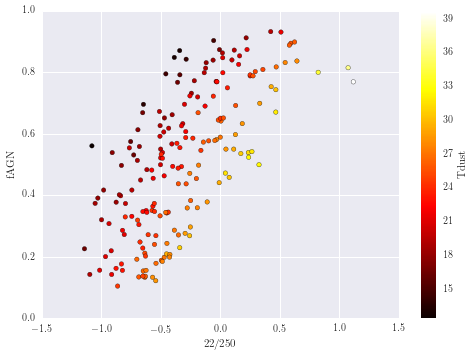

In [20]:
plt.scatter(np.log10(flux_ratios['W4/H250'][flux_ratios['agn_frac_flag']==0]), flux_ratios['agn_frac'][flux_ratios['agn_frac_flag']==0],
            c=flux_ratios['tdust'][flux_ratios['agn_frac_flag']==0], s=20, cmap='hot')
plt.colorbar(label='Tdust')
plt.xlabel('22/250')
plt.ylabel('fAGN')
plt.savefig('fagn_vs_f22_f250_ratio.pdf', bbox_inches='tight')